In [1]:
using Plots; gr();
try
    using Chron
catch
    Pkg.clone("https://github.com/brenhinkeller/Chron.jl")
    using Chron
end

## Enter sample information
This example data is from Clyde et al. (2016) "Direct high-precision
U–Pb geochronology of the end-Cretaceous extinction and calibration of
Paleocene astronomical timescales" EPSL 452, 272–280.
doi: 10.1016/j.epsl.2016.07.041

In [2]:
Name   =        ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",);
Height =        [     -52.0,      44.0,      54.0,      82.0,      93.0,];
Height_Sigma =  [       3.0,       1.0,       3.0,       3.0,       3.0,];
inputSigmaLevel = 2; # i.e., are the data files 1-sigma or 2-sigma. Integer.
Path = "examples/DenverUPbExampleData/" # Where are the data files?
AgeUnit = "Ma" # Unit of measurement for ages and errors in the data files
HeightUnit = "cm" # Unit of measurement for Height and Height_Sigma

# Count the names to see how many samples we have
nSamples = length(Name);
# Make an instance of a ChronSection object with
smpl = StratAgeData(
    Name,  # Sample names
    Height,  # Sample heights
    Height_Sigma,  # Height_sigma
    fill(NaN,nSamples),  # Sample ages
    fill(NaN,nSamples),  # Sample age uncertainty
    fill(NaN,nSamples),  # Sample age 2.5% CI
    fill(NaN,nSamples),  # Sample age 97.5% CI
    zeros(nSamples), # Sidedness (zeros by default, geochron constraints are two-sided)
    fill(NaN,5,nSamples), # Sample age distribution parameters
    Path, # Relative path where we can find .csv data files
    inputSigmaLevel,# i.e., are the data files 1-sigma or 2-sigma
)

Chron.StratAgeData(("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70"), [-52.0, 44.0, 54.0, 82.0, 93.0], [3.0, 1.0, 3.0, 3.0, 3.0], [NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN], [0.0, 0.0, 0.0, 0.0, 0.0], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], "examples/DenverUPbExampleData/", 2)

## Configure and run distribution model

In [3]:
# Number of steps to run in distribution MCMC
distSteps = 10^6;
distBurnin = floor(Int,distSteps/100);

# Choose the form of the prior distribution to use
# A variety of potentially useful distributions are provided in DistMetropolis.jl
# Options include UniformDisribution, TriangularDistribution,
# BootstrappedDistribution, and MeltsVolcanicZirconDistribution
# or you can define your own.
dist = TriangularDistribution;

In [4]:
# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist);

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


## Configure and run stratigraphic model

In [5]:
# If you in doubt, you can probably leave these parameters as-is
resolution = 1. # Same units as sample height. Smaller is slower!
(bottom, top) = extrema(smpl.Height);
bounding = 0.1; # how far away do we place runaway bounds, as a fraction of total section height
npoints_approx = round(Int,length(bottom:resolution:top) * (1+2*bounding))

# Probably want more steps in a production environment, but we'll use 2000 and 3000 for this demo
burnin = 2000*npoints_approx; 
nsteps = 3000;

sieve = round(Int,npoints_approx);

# Pass configuration to a struct
config = StratAgeModelConfiguration(
    resolution, # Resolution
    burnin, # Lenght of burnin
    nsteps, # Number of regular MC steps
    sieve, # Seive strength
    bounding, # Runaway bounds
)

Chron.StratAgeModelConfiguration(1.0, 1750000, 15000, 175, 0.1)

In [6]:
# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolisDist(smpl, config);

Generating stratigraphic age-depth model...
Burn-in: 1750000 steps


Burn-in... 96%|███████████████████████████████████████  |  ETA: 0:00:09

Burn-in...100%|█████████████████████████████████████████| Time: 0:03:19
Collecting...100%|██████████████████████████████████████| Time: 0:05:05


## Plot results

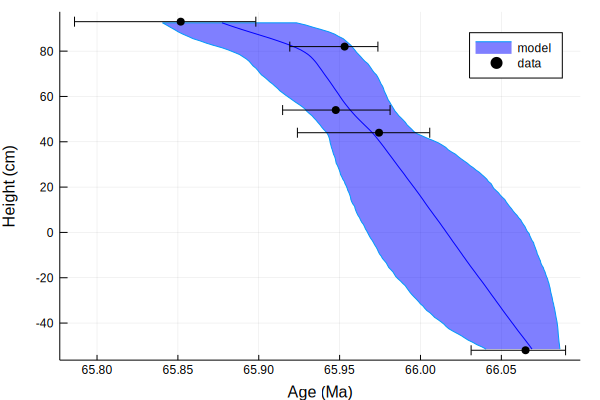

In [7]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="")
plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($AgeUnit)", ylabel="Height ($HeightUnit)")
savefig(hdl,"AgeDepthModel.pdf");
display(hdl)

In [8]:
# Interpolate results at KTB (height = 0)
KTB = linterp1s(mdl.Height,mdl.Age,0)
KTB_min = linterp1s(mdl.Height,mdl.Age_025CI,0)
KTB_max = linterp1s(mdl.Height,mdl.Age_975CI,0)
@printf("Interpolated age: %0.3f +%0.3f/-%0.3f Ma", KTB, KTB_max-KTB, KTB-KTB_min)

Interpolated age: 66.016 +0.050/-0.049 Ma